# Image Captioning with Transformers
You have now implemented a vanilla RNN and for the task of image captioning. In this notebook you will implement key pieces of a transformer decoder to accomplish the same task.

**NOTE:** This notebook will be primarily written in PyTorch rather than NumPy, unlike the RNN notebook. 

In [1]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.transformer_layers import *
from cs231n.captioning_solver_transformer import CaptioningSolverTransformer
from cs231n.classifiers.transformer import CaptioningTransformer
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# COCO Dataset
As in the previous notebooks, we will use the COCO dataset for captioning.

In [2]:
# Load COCO data from disk into a dictionary.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /home/d3ac/Desktop/cs231n/assignment3/cs231n/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# Transformer
As you have seen, RNNs are incredibly powerful but often slow to train. Further, RNNs struggle to encode long-range dependencies (though LSTMs are one way of mitigating the issue). In 2017, Vaswani et al introduced the Transformer in their paper ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) to a) introduce parallelism and b) allow models to learn long-range dependencies. The paper not only led to famous models like BERT and GPT in the natural language processing community, but also an explosion of interest across fields, including vision. While here we introduce the model in the context of image captioning, the idea of attention itself is much more general.



# Transformer: Multi-Headed Attention

### Dot-Product Attention

Recall that attention can be viewed as an operation on a query $q\in\mathbb{R}^d$, a set of value vectors $\{v_1,\dots,v_n\}, v_i\in\mathbb{R}^d$, and a set of key vectors $\{k_1,\dots,k_n\}, k_i \in \mathbb{R}^d$, specified as

\begin{align}
c = \sum_{i=1}^{n} v_i \alpha_i &\alpha_i = \frac{\exp(k_i^\top q)}{\sum_{j=1}^{n} \exp(k_j^\top q)} \\
\end{align}

where $\alpha_i$ are frequently called the "attention weights", and the output $c\in\mathbb{R}^d$ is a correspondingly weighted average over the value vectors.

### Self-Attention
In Transformers, we perform self-attention, which means that the values, keys and query are derived from the input $X \in \mathbb{R}^{\ell \times d}$, where $\ell$ is our sequence length. Specifically, we learn parameter matrices $V,K,Q \in \mathbb{R}^{d\times d}$ to map our input $X$ as follows:

\begin{align}
v_i = Vx_i\ \ i \in \{1,\dots,\ell\}\\
k_i = Kx_i\ \ i \in \{1,\dots,\ell\}\\
q_i = Qx_i\ \ i \in \{1,\dots,\ell\}
\end{align}

### Multi-Headed Scaled Dot-Product Attention
In the case of multi-headed attention, we learn a parameter matrix for each head, which gives the model more expressivity to attend to different parts of the input. Let $h$ be number of heads, and $Y_i$ be the attention output of head $i$. Thus we learn individual matrices $Q_i$, $K_i$ and $V_i$. To keep our overall computation the same as the single-headed case, we choose $Q_i \in \mathbb{R}^{d\times d/h}$, $K_i \in \mathbb{R}^{d\times d/h}$ and $V_i \in \mathbb{R}^{d\times d/h}$. Adding in a scaling term $\frac{1}{\sqrt{d/h}}$ to our simple dot-product attention above, we have

\begin{equation} 
Y_i = \text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)(XV_i)
\end{equation}

where $Y_i\in\mathbb{R}^{\ell \times d/h}$, where $\ell$ is our sequence length.

In our implementation, we apply dropout to the attention weights (though in practice it could be used at any step):

\begin{equation} 
Y_i = \text{dropout}\bigg(\text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)\bigg)(XV_i)
\end{equation}

Finally, then the output of the self-attention is a linear transformation of the concatenation of the heads:

\begin{equation}
Y = [Y_1;\dots;Y_h]A
\end{equation}

were $A \in\mathbb{R}^{d\times d}$ and $[Y_1;\dots;Y_h]\in\mathbb{R}^{\ell \times d}$.

Implement multi-headed scaled dot-product attention in the `MultiHeadAttention` class in the file `cs231n/transformer_layers.py`. The code below will check your implementation. The relative error should be less than `e-3`.

In [3]:
torch.manual_seed(231)

# Choose dimensions such that they are all unique for easier debugging:
# Specifically, the following values correspond to N=1, H=2, T=3, E//H=4, and E=8.
batch_size = 1
sequence_length = 3
embed_dim = 8
attn = MultiHeadAttention(embed_dim, num_heads=2)

# Self-attention.
data = torch.randn(batch_size, sequence_length, embed_dim)
self_attn_output = attn(query=data, key=data, value=data)

# Masked self-attention.
mask = torch.randn(sequence_length, sequence_length) < 0.5
masked_self_attn_output = attn(query=data, key=data, value=data, attn_mask=mask)

# Attention using two inputs.
other_data = torch.randn(batch_size, sequence_length, embed_dim)
attn_output = attn(query=data, key=other_data, value=other_data)

expected_self_attn_output = np.asarray([[
[-0.2494,  0.1396,  0.4323, -0.2411, -0.1547,  0.2329, -0.1936,
          -0.1444],
         [-0.1997,  0.1746,  0.7377, -0.3549, -0.2657,  0.2693, -0.2541,
          -0.2476],
         [-0.0625,  0.1503,  0.7572, -0.3974, -0.1681,  0.2168, -0.2478,
          -0.3038]]])

expected_masked_self_attn_output = np.asarray([[
[-0.1347,  0.1934,  0.8628, -0.4903, -0.2614,  0.2798, -0.2586,
          -0.3019],
         [-0.1013,  0.3111,  0.5783, -0.3248, -0.3842,  0.1482, -0.3628,
          -0.1496],
         [-0.2071,  0.1669,  0.7097, -0.3152, -0.3136,  0.2520, -0.2774,
          -0.2208]]])

expected_attn_output = np.asarray([[
[-0.1980,  0.4083,  0.1968, -0.3477,  0.0321,  0.4258, -0.8972,
          -0.2744],
         [-0.1603,  0.4155,  0.2295, -0.3485, -0.0341,  0.3929, -0.8248,
          -0.2767],
         [-0.0908,  0.4113,  0.3017, -0.3539, -0.1020,  0.3784, -0.7189,
          -0.2912]]])

print('self_attn_output error: ', rel_error(expected_self_attn_output, self_attn_output.detach().numpy()))
print('masked_self_attn_output error: ', rel_error(expected_masked_self_attn_output, masked_self_attn_output.detach().numpy()))
print('attn_output error: ', rel_error(expected_attn_output, attn_output.detach().numpy()))

self_attn_output error:  0.0003775124598178026
masked_self_attn_output error:  0.0001526367643724865
attn_output error:  0.0003530104862933477


# Positional Encoding

While transformers are able to easily attend to any part of their input, the attention mechanism has no concept of token order. However, for many tasks (especially natural language processing), relative token order is very important. To recover this, the authors add a positional encoding to the embeddings of individual word tokens.

Let us define a matrix $P \in \mathbb{R}^{l\times d}$, where $P_{ij} = $

$$
\begin{cases}
\text{sin}\left(i \cdot 10000^{-\frac{j}{d}}\right) & \text{if j is even} \\
\text{cos}\left(i \cdot 10000^{-\frac{(j-1)}{d}}\right) & \text{otherwise} \\
\end{cases}
$$

Rather than directly passing an input $X \in \mathbb{R}^{l\times d}$ to our network, we instead pass $X + P$.

Implement this layer in `PositionalEncoding` in `cs231n/transformer_layers.py`. Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-3` or less.

In [4]:
torch.manual_seed(231)

batch_size = 1
sequence_length = 2
embed_dim = 6
data = torch.randn(batch_size, sequence_length, embed_dim)

pos_encoder = PositionalEncoding(embed_dim)
output = pos_encoder(data)

expected_pe_output = np.asarray([[[-1.2340,  1.1127,  1.6978, -0.0865, -0.0000,  1.2728],
                                  [ 0.9028, -0.4781,  0.5535,  0.8133,  1.2644,  1.7034]]])

print('pe_output error: ', rel_error(expected_pe_output, output.detach().numpy()))

pe_output error:  0.00010421011374914356


# Inline Question 1

Several key design decisions were made in designing the scaled dot product attention we introduced above. Explain why the following choices were beneficial:
1. Using multiple attention heads as opposed to one.
2. Dividing by $\sqrt{d/h}$ before applying the softmax function. Recall that $d$ is the feature dimension and $h$ is the number of heads.
3. Adding a linear transformation to the output of the attention operation.

Only one or two sentences per choice is necessary, but be sure to be specific in addressing what would have happened without each given implementation detail, why such a situation would be suboptimal, and how the proposed implementation improves the situation.

**Your Answer:** 

1. 使用了多个注意力头而不是一个，这样可以学到不同的模式，这个设计和卷积的多通道差不多，再然后作者的意思，使用注意力机制其实是会降低分辨率的，因为最后那个是一个加权和，所以为了减少or抵消这种影响，使用多头。
2. 做softmax的时候，我们希望的就是置信的就在很右边等于1，不太置信的就在左边等于0，如果这个地方不做这样一个除法，那么他们的分布就会分布在两侧，就会导致梯度消失或者说训练速度非常的减小，除一下就会被拉到中间，就有梯度了，便于训练。
3. 增加一点可以学习的参数，并且因为linear的输入已经包含了之前的能够获取的所有信息了，把所有的头的信息做一个融合，然后也可以做一个shape的变换。

# Transformer for Image Captioning
Now that you have implemented the previous layers, you can combine them to build a Transformer-based image captioning model. Open the file `cs231n/classifiers/transformer.py` and look at the `CaptioningTransformer` class.

Implement the `forward` function of the class. After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-5` or less.

In [5]:
torch.manual_seed(231)
np.random.seed(231)

N, D, W = 4, 20, 30
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 3

transformer = CaptioningTransformer(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    num_heads=2,
    num_layers=2,
    max_length=30
)

# Set all model parameters to fixed values
for p in transformer.parameters():
    p.data = torch.tensor(np.linspace(-1.4, 1.3, num=p.numel()).reshape(*p.shape))

features = torch.tensor(np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D))
captions = torch.tensor((np.arange(N * T) % V).reshape(N, T))

scores = transformer(features, captions)
expected_scores = np.asarray([[[-16.9532,   4.8261,  26.6054],
         [-17.1033,   4.6906,  26.4844],
         [-15.0708,   4.1108,  23.2924]],
        [[-17.1767,   4.5897,  26.3562],
         [-15.6017,   4.8693,  25.3403],
         [-15.1028,   4.6905,  24.4839]],
        [[-17.2172,   4.7701,  26.7574],
         [-16.6755,   4.8500,  26.3754],
         [-17.2172,   4.7701,  26.7574]],
        [[-16.3669,   4.1602,  24.6872],
         [-16.7897,   4.3467,  25.4831],
         [-17.0103,   4.7775,  26.5652]]])
print('scores error: ', rel_error(expected_scores, scores.detach().numpy()))

scores error:  5.056720614342753e-06


# Overfit Transformer Captioning Model on Small Data
Run the following to overfit the Transformer-based captioning model on the same small dataset as we used for the RNN previously.

base dir  /home/d3ac/Desktop/cs231n/assignment3/cs231n/datasets/coco_captioning
(Iteration 1 / 200) loss: 5.023862
(Iteration 11 / 200) loss: 2.838874
(Iteration 21 / 200) loss: 1.969267
(Iteration 31 / 200) loss: 1.578102
(Iteration 41 / 200) loss: 1.207836
(Iteration 51 / 200) loss: 1.057460
(Iteration 61 / 200) loss: 0.732079
(Iteration 71 / 200) loss: 0.661590
(Iteration 81 / 200) loss: 0.444574
(Iteration 91 / 200) loss: 0.345618
(Iteration 101 / 200) loss: 0.256596
(Iteration 111 / 200) loss: 0.118197
(Iteration 121 / 200) loss: 0.085366
(Iteration 131 / 200) loss: 0.083801
(Iteration 141 / 200) loss: 0.061836
(Iteration 151 / 200) loss: 0.061421
(Iteration 161 / 200) loss: 0.043642
(Iteration 171 / 200) loss: 0.044424
(Iteration 181 / 200) loss: 0.021260
(Iteration 191 / 200) loss: 0.024168


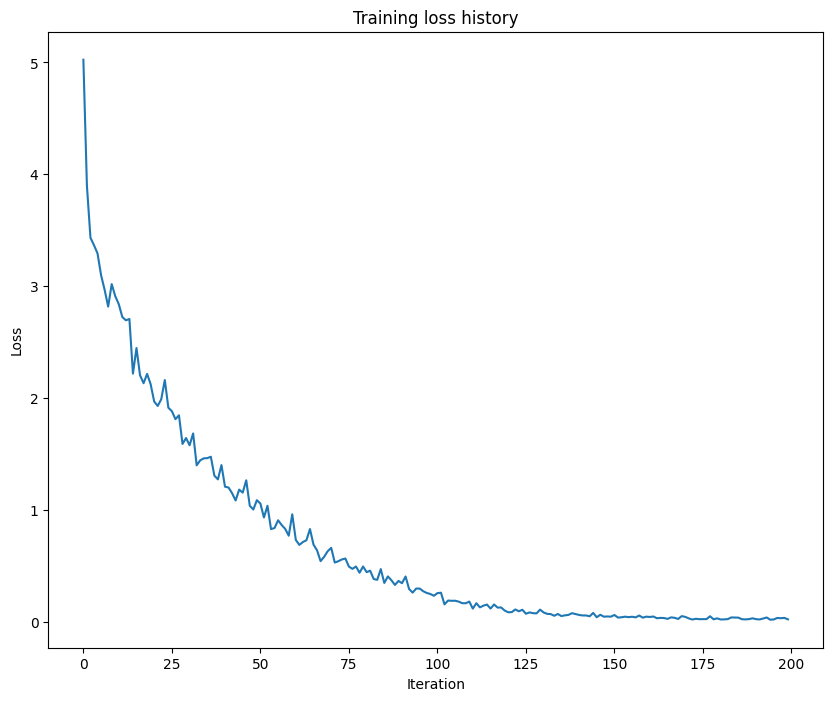

In [12]:
torch.manual_seed(231)
np.random.seed(231)

data = load_coco_data(max_train=50)

transformer = CaptioningTransformer(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_layers=2,
          max_length=30
        )


transformer_solver = CaptioningSolverTransformer(transformer, data, idx_to_word=data['idx_to_word'],
           num_epochs=100,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=10,
         )

transformer_solver.train()

# Plot the training losses.
plt.plot(transformer_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.03.

In [7]:
print('Final loss: ', transformer_solver.loss_history[-1])

Final loss:  0.02235897


# Transformer Sampling at Test Time
The sampling code has been written for you. You can simply run the following to compare with the previous results with the RNN. As before the training results should be much better than the validation set results, given how little data we trained on.

URL Error:  Gone http://farm1.staticflickr.com/202/487987371_489a65d670_z.jpg


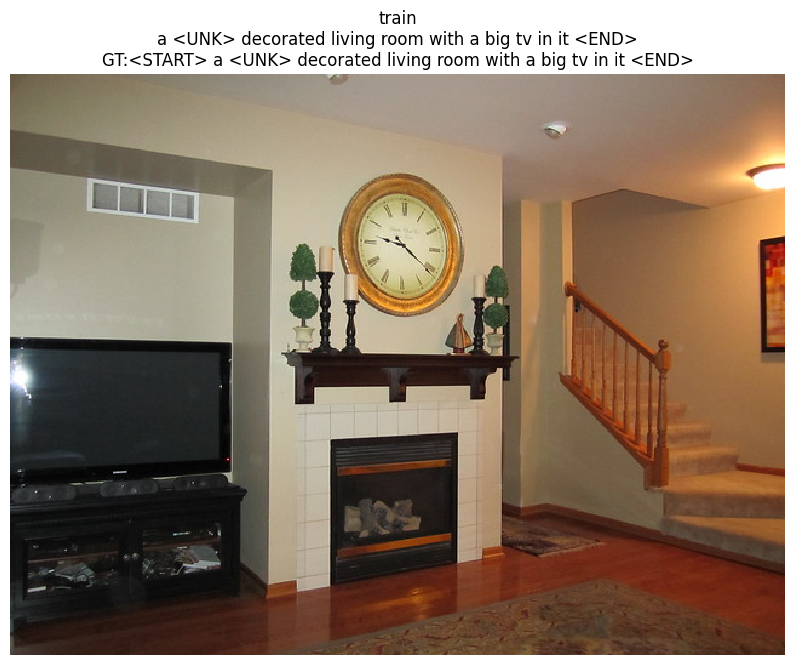

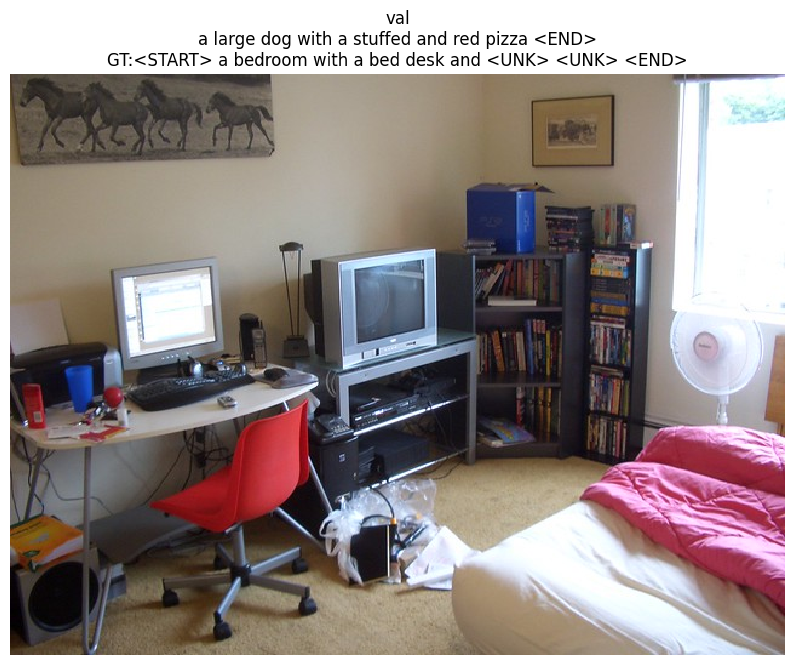

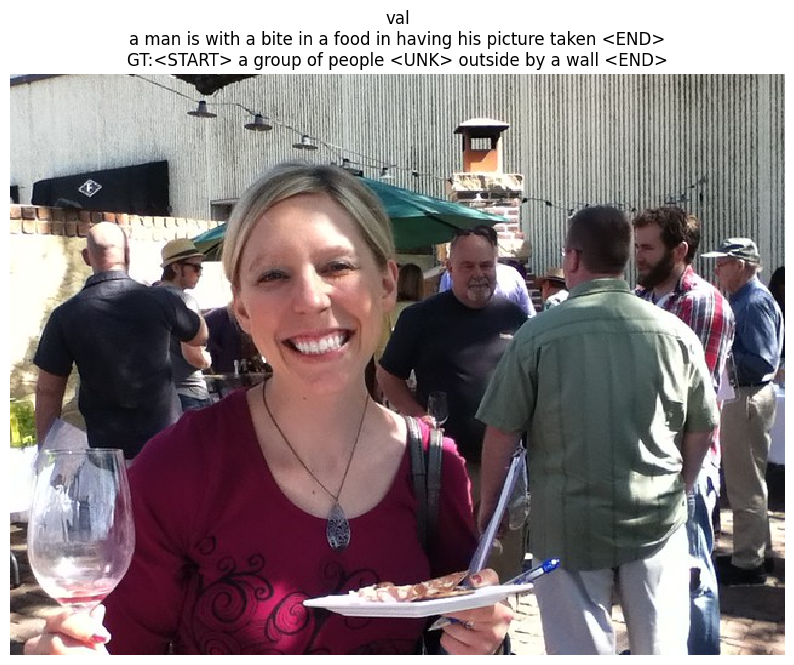

In [8]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = transformer.sample(features, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)            
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()